# Project Part 1
## Question 1
### Imports and Data Wrangling

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import brentq

ois = pd.read_excel("IR Data.xlsx", sheet_name = 'OIS', usecols = ["Tenor", "Product", "Rate"])

In [25]:
#tenors = ['6m', '1y', '2y', '3y', '4y', '5y', '7y', '10y', '15y', '20y', '30y']
tenors = ois["Tenor"]

# Define a function to convert tenor strings to years
def tenor_to_years(tenor):
    if 'm' in tenor:
        return int(tenor.replace('m', '')) / 12
    elif 'y' in tenor:
        return int(tenor.replace('y', ''))
    else:
        return None

# Convert each tenor to years
ois["years"] = [tenor_to_years(tenor) for tenor in tenors]

# Add place holder for Discount Factors and cumsum of discount factors
ois[['f', 'cumsum_df','df']] = np.nan
ois

,Tenor,Product,Rate,years,f,cumsum_df,df
0,6m,OIS,0.00250,0.5,NaN,NaN,NaN
1,1y,OIS,0.00300,1.0,NaN,NaN,NaN
2,2y,OIS,0.00325,2.0,NaN,NaN,NaN
3,3y,OIS,0.00335,3.0,NaN,NaN,NaN
4,4y,OIS,0.00350,4.0,NaN,NaN,NaN
5,5y,OIS,0.00360,5.0,NaN,NaN,NaN
6,7y,OIS,0.00400,7.0,NaN,NaN,NaN
7,10y,OIS,0.00450,10.0,NaN,NaN,NaN
8,15y,OIS,0.00500,15.0,NaN,NaN,NaN
9,20y,OIS,0.00525,20.0,NaN,NaN,NaN


### Solve for year 1 Discount Factor
Use the swap formula where we consider a par swap as the following:
$$
\sum_{i=1}^{n} D(0, T_i) \times \Delta_{i-1} \times L(T_{i-1}, T_i) = 1 - D(0, T_n) \\
\sum_{i=1}^{n} D(0, T_i) \times \Delta_{i-1} \times L(T_{i-1}, T_i) - (1 - D(0, T_n))= 0 \tag{1}
$$
Equation (1) can be a function of the unknown discount factor and can be used as objective function. After using Solver to find the root of equation (1), this root is the Discount Factor(df) for that year.

In [26]:
def payer_ois_swap_1y(df, ois_rate):
    """
    Return PV of payer swap i.e. PV of fixed leg minus PV of floating leg 
    FOR FIRST YEAR ONLY
    paramters:
        df: discount factor a year
        ois_rate: rate for the same year
    Assume annual payout since day count fraction is not included
    """
    return ois_rate*df - (1 - df)
    
guess = 0.99

ois.at[1, 'df'] = fsolve(payer_ois_swap_1y, 
                         guess, 
                         args=(ois.at[1, 'Rate']))[0]
ois.at[1, 'cumsum_df'] = ois.at[1, 'df']
ois

,Tenor,Product,Rate,years,f,cumsum_df,df
0,6m,OIS,0.00250,0.5,NaN,NaN,NaN
1,1y,OIS,0.00300,1.0,NaN,0.997009,0.997009
2,2y,OIS,0.00325,2.0,NaN,NaN,NaN
3,3y,OIS,0.00335,3.0,NaN,NaN,NaN
4,4y,OIS,0.00350,4.0,NaN,NaN,NaN
5,5y,OIS,0.00360,5.0,NaN,NaN,NaN
6,7y,OIS,0.00400,7.0,NaN,NaN,NaN
7,10y,OIS,0.00450,10.0,NaN,NaN,NaN
8,15y,OIS,0.00500,15.0,NaN,NaN,NaN
9,20y,OIS,0.00525,20.0,NaN,NaN,NaN


### Solve for 2y to 5y

In [4]:
ois.at[2-1,'cumsum_df']

0.9970089730807578

In [5]:
def payer_ois_swap_2y(df, ois_rate, cumsum_df):
    """
    Return PV of payer swap i.e. PV of fixed leg minus PV of floating leg
    ONLY FOR YEARS WITH NO GAPS
    paramters:
        df: discount factor a year
        ois_rate: rate for the same year
        cumsum_df: cumulative sum of df up till the year earlier
    Assume annual payout since day count fraction is not included
    """
    sum_df = cumsum_df + df
    return ois_rate*sum_df - (1 - df)
    
guess = 0.99

for i in range(2,6):
    DF = fsolve(payer_ois_swap_2y, 
                guess, 
                args=(ois.at[i,'Rate'], 
                      ois.at[i-1,'cumsum_df']))[0]
    ois.at[i,'df'] = DF
    ois.cumsum_df = ois.df.cumsum()

ois

,Tenor,Product,Rate,years,cumsum_df,df
0,6m,OIS,0.00250,0.5,NaN,NaN
1,1y,OIS,0.00300,1.0,0.997009,0.997009
2,2y,OIS,0.00325,2.0,1.990540,0.993531
3,3y,OIS,0.00335,3.0,2.980555,0.990015
4,4y,OIS,0.00350,4.0,3.966672,0.986117
5,5y,OIS,0.00360,5.0,4.948856,0.982184
6,7y,OIS,0.00400,7.0,NaN,NaN
7,10y,OIS,0.00450,10.0,NaN,NaN
8,15y,OIS,0.00500,15.0,NaN,NaN
9,20y,OIS,0.00525,20.0,NaN,NaN


### Solve for years with gaps
The sum of discount factors is known since the preceding years have OIS rates for equation (1) to be solved. However for some e.g. 7y there is a gap of year 6. In this case assume that sequendce of df from year 5 to 7 is linear. 
$$
\sum_{k=i}^{N+i} D(0, T_i) = \frac{D(0,T_i) + D(0,T_{i+N})}{2} \times (N+1)
$$
In that case the cumulative sum still can be calculated by using the average of the latest and computed years.

In [6]:
def payer_ois_swap_7y(df, i, ois):
    """
    Return PV of payer swap i.e. PV of fixed leg minus PV of floating leg
    ONLY FOR YEARS WITH GAPS FROM PRECEDING YEARS
    paramters:
        df:         discount factor a year
        i:          pointer of in ois_rate DataFrame
        ois_rate:   rate for the same year
    Assume annual payout since day count fraction is not included
    """
    known_sum = ois.at[i-1, 'cumsum_df']

    N = ois.at[i, 'years'] - ois.at[i-1, 'years']
    ave_df = (df + ois.at[i-1,'df'])/2   
    interp_sum = (N+1) * ave_df - ois.at[i-1,'df']     # less the earliest term since it is in known_sum

    ois_rate = ois.at[i, 'Rate']
    
    return (known_sum + interp_sum) * ois_rate - (1-df)

for i in range(6,len(ois)):
    # solve for gapped df
    DF = fsolve(payer_ois_swap_7y,
                guess, 
                args=(i,ois))[0]
    # get the average df and cumulative df over gap
    N = ois.at[i, 'years'] - ois.at[i-1, 'years']
    ave_df = (DF + ois.at[i-1,'df'])/2   
    interp_sum = (N+1) * ave_df - ois.at[i-1,'df']
    # assign df and cumsum_df values for this gap year
    ois.at[i,'df'] = DF
    ois.at[i,'cumsum_df'] = ois.at[i-1,'cumsum_df'] + interp_sum 

ois

,Tenor,Product,Rate,years,cumsum_df,df
0,6m,OIS,0.00250,0.5,NaN,NaN
1,1y,OIS,0.00300,1.0,0.997009,0.997009
2,2y,OIS,0.00325,2.0,1.990540,0.993531
3,3y,OIS,0.00335,3.0,2.980555,0.990015
4,4y,OIS,0.00350,4.0,3.966672,0.986117
5,5y,OIS,0.00360,5.0,4.948856,0.982184
6,7y,OIS,0.00400,7.0,6.898556,0.972406
7,10y,OIS,0.00450,10.0,9.782916,0.955977
8,15y,OIS,0.00500,15.0,14.477704,0.927611
9,20y,OIS,0.00525,20.0,19.033155,0.900076


### Solve for 6m rate

In [7]:
def payer_ois_swap_6m(df, ois_rate):
    """
    Return PV of payer swap i.e. PV of fixed leg minus PV of floating leg 
    FOR FIRST YEAR ONLY
    paramters:
        df: discount factor a year
        ois_rate: rate for the same year
    Assume annual payout since day count fraction is not included
    """
    return ois_rate*.5*df - (1 - df)


ois.at[0, 'df'] = fsolve(payer_ois_swap_6m, 
                         guess, 
                         args=(ois.at[0, 'Rate']))[0]

In [8]:
ois

,Tenor,Product,Rate,years,cumsum_df,df
0,6m,OIS,0.00250,0.5,NaN,0.998752
1,1y,OIS,0.00300,1.0,0.997009,0.997009
2,2y,OIS,0.00325,2.0,1.990540,0.993531
3,3y,OIS,0.00335,3.0,2.980555,0.990015
4,4y,OIS,0.00350,4.0,3.966672,0.986117
5,5y,OIS,0.00360,5.0,4.948856,0.982184
6,7y,OIS,0.00400,7.0,6.898556,0.972406
7,10y,OIS,0.00450,10.0,9.782916,0.955977
8,15y,OIS,0.00500,15.0,14.477704,0.927611
9,20y,OIS,0.00525,20.0,19.033155,0.900076


### Interpolate semi-annual DF and cumsum

In [9]:
# Generate the full sequence
full_sequence = np.arange(0.5, 30.5, 0.5)
# Convert 'years' column of your DataFrame to a list
existing_years = ois['years'].tolist()
# Remove the existing years from the full sequence
new_years = [year for year in full_sequence if year not in existing_years]

additional_years = pd.DataFrame({
    'years': new_years,
    'Rate': [np.nan]*len(new_years),
    'df': [np.nan]*len(new_years)
})
ois = pd.concat([additional_years, ois])
ois = ois.sort_values(by='years')\
        .reset_index(drop=True)
ois['df'] = ois['df'].interpolate(method='linear')
ois['cumsum_df'] = ois['df'].cumsum()

ois.head(10)

,years,Rate,df,Tenor,Product,cumsum_df
0,0.5,0.00250,0.998752,6m,OIS,0.998752
1,1.0,0.00300,0.997009,1y,OIS,1.995761
2,1.5,NaN,0.995270,NaN,NaN,2.991030
3,2.0,0.00325,0.993531,2y,OIS,3.984561
4,2.5,NaN,0.991773,NaN,NaN,4.976334
5,3.0,0.00335,0.990015,3y,OIS,5.966349
6,3.5,NaN,0.988066,NaN,NaN,6.954415
7,4.0,0.00350,0.986117,4y,OIS,7.940532
8,4.5,NaN,0.984150,NaN,NaN,8.924682
9,5.0,0.00360,0.982184,5y,OIS,9.906866


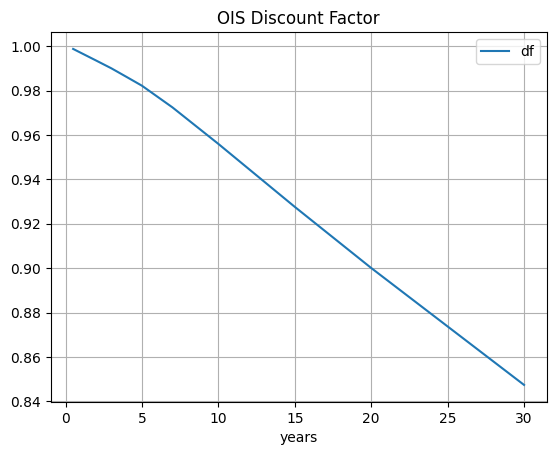

In [20]:
ois.plot(x='years',y='df')
plt.title("OIS Discount Factor")
plt.grid(True)
plt.show()

## Question 2
### Imports and Data Wrangling

In [11]:
irs = pd.read_excel("IR Data.xlsx", sheet_name = 'IRS', usecols = ["Tenor", "Product", "Rate"])
# Convert each tenor to years
irs["years"] = [tenor_to_years(tenor) for tenor in tenors]
# Convert 'years' column of your DataFrame to a list
existing_years = irs['years'].tolist()
# Remove the existing years from the full sequence
new_years = [year for year in full_sequence if year not in existing_years]

additional_years = pd.DataFrame({
    'years': new_years,
    'Rate': [np.nan]*len(new_years),
    'ois_df': [np.nan]*len(new_years),
    'libor_df': [np.nan]*len(new_years)
})
irs = pd.concat([additional_years, irs])\
        .sort_values(by='years')\
        .reset_index(drop=True)
irs['ois_df'] = ois.df
irs.head()

,years,Rate,ois_df,libor_df,Tenor,Product
0,0.5,0.025,0.998752,NaN,6m,LIBOR
1,1.0,0.028,0.997009,NaN,1y,IRS
2,1.5,NaN,0.995270,NaN,NaN,NaN
3,2.0,0.030,0.993531,NaN,2y,IRS
4,2.5,NaN,0.991773,NaN,NaN,NaN


### solve for IRS swap with OIS discount factors

$$
\sum^N_{i=1} D_o(0,T_i) \times \Delta_i \times IRS = \sum^N_{i=1} D_o(0,T_i) \times L(T_{i-1}, T_i) \\
\sum^N_{i=1} D_o(0,T_i) \times \Delta_i \times IRS - \sum^N_{i=1} D_o(0,T_i) \times L(T_{i-1}, T_i)  = 0 \\ 
\sum^N_{i=1} D_o(0,T_i) \times \Delta_i \times IRS - \sum^N_{i=1} D_o(0,T_i) 
\times \left[\frac{D(0,T_{i-1})-D(0,T_{i})}{D(0,T_{i})}\right]  = 0 \\ 
$$

where $L(T_{i-1}, T_i) = \left[\frac{D(0,T_{i-1})-D(0,T_{i})}{D(0,T_{i})}\right]$

First obtain LIBOR discount factor

In [12]:
irs.at[0,'libor_df'] = 1/(1+irs.at[0,'Rate']*.5)

irs.head(5)

,years,Rate,ois_df,libor_df,Tenor,Product
0,0.5,0.025,0.998752,0.987654,6m,LIBOR
1,1.0,0.028,0.997009,NaN,1y,IRS
2,1.5,NaN,0.995270,NaN,NaN,NaN
3,2.0,0.030,0.993531,NaN,2y,IRS
4,2.5,NaN,0.991773,NaN,NaN,NaN


In [13]:
def payer_irs_swap(df, i, irs):
    """
    Return value of payer swap
    """
    irs1 = irs.copy()
    irs1.at[i,'libor_df'] = df
    irs1[['years','libor_df']] = irs1[['years','libor_df']].interpolate(method='linear')

    # fix_leg = cumsum_ois_df * 0.5 * IRS
    cumsum_ois_df = irs1['ois_df'].iloc[:i+1].sum()
    irs_rate = irs1.at[i,'Rate']
    fix_leg = cumsum_ois_df * 0.5 * irs_rate

    # float leg = D_o(j) * (D(j-1)-D(j))/D(j) for j in range i
    float_leg = irs1.at[0,'ois_df'] * (1-irs1.at[0,'libor_df']) / irs1.at[0,'libor_df']
    for j in range(1,i+1):
        float_leg += irs1.at[j,'ois_df'] * (irs1.at[j-1,'libor_df']-irs1.at[j,'libor_df']) \
                                            / irs1.at[j,'libor_df']

    return fix_leg - float_leg
# collate list of indices with IRS swaps
idx_irs = irs[irs['Product'] == "IRS"].index[1:]
guess = .99

for i in idx_irs:       # skip first index since already computed
        x = fsolve(payer_irs_swap,
                    guess,
                    args=(i,irs))[0]
        irs.at[i, 'libor_df'] = x
        guess = x                       # IMPORTANT to update guess, there is multiple roots
irs['libor_df'] = irs['libor_df'].interpolate(method='linear')

In [14]:
irs.tail()

,years,Rate,ois_df,libor_df,Tenor,Product
55,28.0,NaN,0.857941,0.260574,NaN,NaN
56,28.5,NaN,0.855307,0.251346,NaN,NaN
57,29.0,NaN,0.852674,0.242118,NaN,NaN
58,29.5,NaN,0.850040,0.232890,NaN,NaN
59,30.0,0.05,0.847407,0.223662,30y,IRS


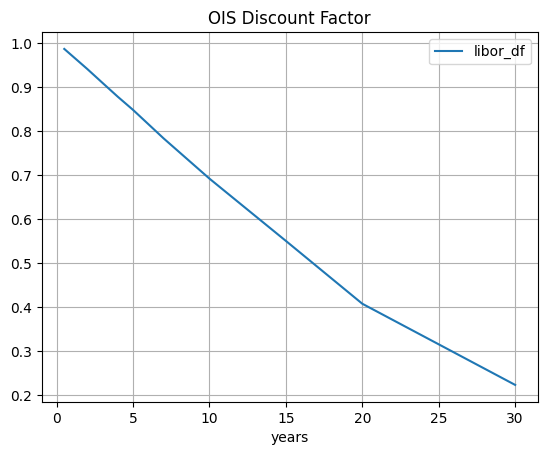

In [22]:
irs.plot(x='years',y='libor_df')
plt.title("OIS Discount Factor")
plt.grid(True)
plt.show()

## Question 3
Solving for FRA will be similar to swaps, however the starting points will differ
$$
\sum^N_{i=s} D_o(0,T_i) \times \Delta_i \times IRS - \sum^N_{i=s} D_o(0,T_i) 
\times \left[\frac{D(0,T_{i-1})-D(0,T_{i})}{D(0,T_{i})}\right]  = 0 \\ 
$$

where $s$ is the start of the rate agreement and N is maturity




In [15]:
def payer_irs_fwd_swap(fwd_swap_rate, start=1, i=1, irs=irs):
    """
    Return value of forward payer swap starting from year 1 ahead
    Parameters:
        fwd_swap_rate:
        start: in years, 
        i: tenor in years, 
        irs: Dataframe of IRS rates, libor/OIS df
    """
    # fix_leg = cumsum_ois_df * 0.5 * IRS
    # for forward starting, deduct the starting period DF
    cumsum_ois_df = irs.loc[irs['years'] <= start+i, 'ois_df'].sum() \
                        - irs.loc[irs['years'] <= start, 'ois_df'].sum()
    fix_leg = cumsum_ois_df * 0.5 * fwd_swap_rate

    # float leg = D_o(j) * (D(j-1)-D(j))/D(j) for j in range i
    float_leg = 0
    for j in range(int(start*2),int((start+i)*2)):
        # print(j, irs.at[j,'libor_df'])
        float_leg += irs.at[j,'ois_df'] * (irs.at[j-1,'libor_df']-irs.at[j,'libor_df']) \
                                            / irs.at[j,'libor_df']

    return fix_leg - float_leg

payer_irs_fwd_swap(.032007, 1, 1, irs)

8.421570529373174e-05

In [16]:
# instantiate FRA table
fra_libor = pd.DataFrame({'start' : [1]*5 + [5]*5 + [10]*5,'tenor' : [1,2,3,5,10]*3, 'fsr': [np.nan]*15})
# iterate through table and get FRA
for idx, row in fra_libor.iterrows():
    fra_libor.at[idx, 'fsr'] = fsolve(payer_irs_fwd_swap,
                                      guess,
                                      args=(row['start'],
                                            row['tenor'],
                                            irs))
fra_libor

,start,tenor,fsr
0,1,1,0.031922
1,1,2,0.033217
2,1,3,0.033982
3,1,5,0.035238
4,1,10,0.038419
5,5,1,0.039274
6,5,2,0.040075
7,5,3,0.040072
8,5,5,0.041093
9,5,10,0.043634
